<div style="font-size:22pt; line-height:25pt; font-weight:bold; text-align:center;">Squash ranking</div>

This notebook aims to rank the SUPAERO squash players using a Elo ranking system.

The Elo method awards points to a player according its chronological results. If he realizes a better performance than its estimated level, he will earn Elo points. Reciprocally, if he loses against a weaker opponent, he will lose some Elo points.

The calculation method is the following:

<div style="text-align:center">$E_{n+1} = E_n + K[W - p(D)]$</div>

where:
$E_n$ is the number of Elo points at time $n$, $K$ is the development factor, $W$ is the result of the game: 1 for a win and 0 for a defeat and $p(D)$ is the probability of winning depending on the difference of points between the two players and is calculated by $p(D) = \frac{1}{1+10^{\frac{-D}{300}}}$. Note that if $D$ is greater than 300, it will be reduced to 300.

Every new player will begin with a ranking of 1000 Elo points. During his first 30 sets, a player will have a high development factor $K=40$ in order to make its ranking rapidly converge to its real level. After that, the development factor will be set to 20. For players having a ranking above 2000 points, the development factor will be reduced to 10.

1. [Algorithm](#sec1)
2. [Results](#sec2)
3. [Postgres database](#sec3)
4. [R&D](#sec4)

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

pd.set_option('mode.chained_assignment',None)

import psycopg2

## 1. <a id="sec1"></a> Algorithm

In [31]:
def proba(D):
    return 1/(1+pow(10,-D/300))

Calculate points for a match

In [32]:
def calculate_points(infos, players, result):
    
    # Get players scores
    points = [infos[player]["Points"] for player in players]
    
    # Get points difference and proba
    D = points[0] - points[1]
    if abs(D) > 300:
        D = np.sign(D)*300
        
    p_D = proba(D)
    
    # Get the evolution of points (for the first player)
    evolution = result[0]*(1-proba(D)) + result[1]*(-proba(D))
    
    for i in range(2):
        player = players[i]
        
        # Update score
        infos[player]["Points"] += int(infos[player]["Developpement"]*(-2*i + 1)*evolution)
        
        # Update number of won sets
        infos[player]["Sets gagnes"] += result[i]
        
        # Update number of won sets
        infos[player]["Sets perdus"] += result[1-i]
        
        # Update number of played sets
        infos[player]["Sets joues"] += sum(result)
        
        # Update development factor
        if infos[player]["Points"] > 1200:
            infos[player]["Developpement"] = 10
            
        if infos[player]["Developpement"] > 10:
            if infos[player]["Sets joues"] > 29:
                infos[player]["Developpement"] = 20

Fill history of matches

In [33]:
def fill_history(infos, match, players):
    
    indices = list(df[df["Date"] == match].index)
    
    for i in range(2):
        player = players[i]
        index = indices[i]
        
        if np.isnan(df.Points[index]):
        
            df["Sets joues"][index] = int(infos[player]["Sets joues"])
            df["Sets perdus"][index] = int(infos[player]["Sets perdus"])
            df["Sets gagnes"][index] = int(infos[player]["Sets gagnes"])
            df["Developpement"][index] = infos[player]["Developpement"]
            df["Points"][index] = infos[player]["Points"]    

Main

In [34]:
df = pd.read_csv("Historique Elo.csv", sep=';', decimal=',')
df.Points = np.nan

infos = {}

for match in list(df.Date.unique()):
    players = list(df[df["Date"]==match]["Joueur"])
    
    # Add player in actual ranking dict
    for player in players:
        if player not in list(infos.keys()):
            new_player = {}
            new_player["Sets joues"] = 0
            new_player["Sets perdus"] = 0
            new_player["Sets gagnes"] = 0
            new_player["Developpement"] = 40
            new_player["Points"] = 1000
            
            infos[player] = new_player
    
    result = list(df[df["Date"]==match]["Scores"])
    
    calculate_points(infos, players, result)
    
    fill_history(infos, match, players)

df = df.astype({'Sets joues': 'int64', 'Sets gagnes': 'int64', 'Sets perdus': 'int64',
                'Developpement': 'int64', 'Points': 'int64'})
    
df.to_csv("Historique Elo.csv", sep=';', decimal=',', index=False)

Change date format to be compatible with Grafana format

In [35]:
for i in df.Date.index:
    str_date = df.Date[i]
    date = datetime.datetime.strptime(str_date, '%d/%m/%Y %H:%M')
    df.Date[i] = datetime.datetime.strftime(date, '%Y-%m-%d %H:%M:%S')

## 2. <a id="sec2"></a> Results

In this section, we define two tables:
- a history of matches
- a final ranking with the players' stats

In [36]:
df_match = df[["Date", "Joueur", "Points"]]

All players start with 1000 points

In [37]:
for player in list(df.Joueur.unique()):
    date0_str = list(df[df["Joueur"]==player]["Date"])[0]    
    date0 = datetime.datetime.strptime(date0_str, '%Y-%m-%d %H:%M:%S')
    
    date_begin = date0 - datetime.timedelta(days=1)
    date_begin_str = datetime.datetime.strftime(date_begin, '%Y-%m-%d %H:%M:%S')

    df_match = df_match.append({"Date":date_begin_str,
                               "Joueur":player,
                               "Points":1000}, ignore_index=True)
    
df_match

,Date,Joueur,Points
0,2021-09-15 22:00:00,Marin,960
1,2021-09-15 22:00:00,Colas,1040
2,2021-09-16 19:54:00,LL,973
3,2021-09-16 19:54:00,Colas,1067
4,2021-09-17 17:49:00,KRa,971
...,...,...,...
446,2021-12-26 04:08:00,Roch,1000
447,2022-01-04 07:15:00,Bossard,1000
448,2022-01-07 22:54:00,Remi,1000
449,2022-01-17 02:01:00,Thibs,1000


In [38]:
df_stats = pd.DataFrame(columns=["Classement", "Joueur", "Points", "Sets joues", "Sets gagnes",
                                 "Sets perdus", "Developpement"])
players = list(df.Joueur.unique())
df_stats["Joueur"] = players

for i in range(len(players)):
    player = players[i]
    df_stats.loc[i] = ["", player, 
                infos[player]["Points"],
                infos[player]["Sets joues"],
                infos[player]["Sets gagnes"],
                infos[player]["Sets perdus"],
                infos[player]["Developpement"]]
    
df_stats.sort_values(by=["Points"], ascending=False, inplace=True)
df_stats["Classement"] = range(1, len(players)+1)
df_stats

,Classement,Joueur,Points,Sets joues,Sets gagnes,Sets perdus,Developpement
3,1,KRa,1245,260,231,29,10
15,2,Bossard,1216,17,17,0,10
1,3,Colas,1087,163,93,70,20
6,4,Mateos,1070,120,48,72,20
7,5,PLN,1054,128,48,80,20
9,6,Xavier,1022,9,4,5,40
12,7,Pele,997,28,14,14,40
8,8,Toujouse,972,11,6,5,40
11,9,Slo,951,9,0,9,40
14,10,Roch,942,5,1,4,40


## 3. <a id="sec3"></a> Postgres database

Connect the database

In [39]:
f = open("Connexion.txt", "r")
f.readline()
host = f.readline()[:-1]
f.readline()
database = f.readline()[:-1]
f.readline()
user = f.readline()[:-1]
f.readline()
password = f.readline()

In [40]:
conn = psycopg2.connect(
    host=host,
    database=database,
    user=user,
    password=password)

Test the connection

In [41]:
cur = conn.cursor()
        
	# execute a statement
print('PostgreSQL database version:')
cur.execute('SELECT version()')

# display the PostgreSQL database server version
db_version = cur.fetchone()
print(db_version)

# close the communication with the PostgreSQL
cur.close()

PostgreSQL database version:
('PostgreSQL 14.2 on x86_64-pc-linux-gnu, compiled by gcc (Debian 8.3.0-6) 8.3.0, 64-bit',)


Drop the existing tables

In [42]:
def drop_table(table_name):
    command = "DROP TABLE IF EXISTS {};".format(table_name)
    cur = conn.cursor()
    cur.execute(command)
    cur.close()
    conn.commit()
    print("Table {} successfully deleted".format(table_name))

In [43]:
drop_table("match")
drop_table("stats")

Table match successfully deleted
Table stats successfully deleted


Create the tables

In [44]:
command_match = """
CREATE TABLE match (
    date timestamp,
    joueur character varying(20) NOT NULL,
    points integer
);
"""

command_rank = """
CREATE TABLE stats (
    rang integer,
    joueur character varying(20) NOT NULL,
    points integer,
    setsj integer,
    setsg integer,
    setsp integer,
    dev integer
);
"""

In [45]:
cur = conn.cursor()
cur.execute(command_match)
cur.execute(command_rank)
cur.close()
conn.commit()

Insert data

In [46]:
def insert_command(df, table):
    insert_data = "INSERT INTO {} VALUES ".format(table)
    n = df.shape[0]
    for i in range(n):
        value = "("
        for elem in list(df.loc[i]):
            value += "'" + str(elem) + "'" + ","
        value = value[:-1]
        value += ')'
        
        insert_data += value + ","
        
    insert_data = insert_data[:-1]
    insert_data += ";"
    return insert_data

In [47]:
cur = conn.cursor()
cur.execute(insert_command(df_match, "match"))
cur.execute(insert_command(df_stats, "stats"))
cur.close()
conn.commit()

Close the connection

In [48]:
conn.close()

## 4. <a id="sec4"></a> R&D

In [19]:
df_r = pd.read_csv("Historique Elo.csv", sep=';', decimal=',')
df_r

,Date,Joueur,Scores,Sets joues,Sets gagnes,Sets perdus,Developpement,Points
0,2021-09-15 22:00:00,Marin,0,2,0,2,40,960
1,2021-09-15 22:00:00,Colas,2,2,2,0,40,1040
2,2021-09-16 18:24:00,LL,1,4,1,3,40,973
3,2021-09-16 18:24:00,Colas,3,6,5,1,40,1067
4,2021-09-17 14:48:00,KRa,0,2,0,2,40,971
...,...,...,...,...,...,...,...,...
393,2022-03-11 22:00:00,Gessien,0,111,44,67,20,966
394,2022-03-12 22:00:00,PLN,3,100,32,68,20,1050
395,2022-03-12 22:00:00,Gessien,0,114,44,70,20,943
396,2022-03-13 22:00:00,PLN,2,103,34,69,20,1049


In [20]:
for match in list(df_r["Date"].unique())[:2]:
    df_local = df_r[df_r["Date"] == match]
    players = list(df_local.Joueur)
    print(players)
    fort = np.argmax(list(df_local["Points"]))
    print(fort)

['Marin', 'Colas']
1
['LL', 'Colas']
1


In [21]:
print(list(df_stats.Points))

[1234, 1216, 1070, 1069, 1049, 1022, 999, 972, 951, 944, 942, 919, 917, 907, 904, 887, 886, 875, 784]


(array([1., 0., 6., 4., 2., 2., 2., 0., 0., 2.]),
 array([ 784.,  829.,  874.,  919.,  964., 1009., 1054., 1099., 1144.,
        1189., 1234.]),
 <a list of 10 Patch objects>)

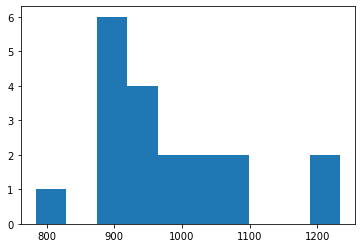

In [22]:
plt.hist(list(df_stats.Points),10)

In [23]:
from sklearn.neighbors import KernelDensity

In [24]:
x = np.array(list(df_stats.Points)).reshape(-1,1)
bins = np.linspace(600,1300,10)
x_plot = np.linspace(600,1300,1000).reshape(-1,1)

In [32]:
kde = KernelDensity(kernel="gaussian", bandwidth=15).fit(x)
log_dens = kde.score_samples(x_plot)

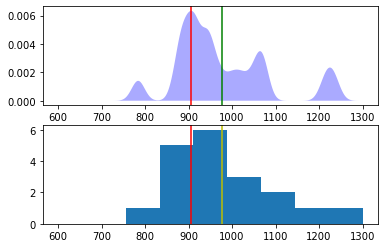

In [33]:
peak = x_plot[np.argmax(log_dens)]

fig = plt.figure()
plt.subplot(2,1,1)
plt.fill(x_plot, np.exp(log_dens), fc="#AAAAFF")
plt.axvline(peak, c='r')
plt.axvline(np.mean(x), c='g')
# plt.
plt.subplot(2,1,2)
plt.hist(x, bins)
plt.axvline(peak, c='r')
plt.axvline(np.mean(x), c='y')
plt.show()

In [27]:
print(np.mean(x))
print(peak)

976.1578947368421
[907.60760761]
